In [8]:
import numpy as np
import time
from matplotlib import pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit import BasicAer
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver
from qiskit.opflow import I, X, Z, Y, StateFn
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import TwoLocal, NLocal
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.opflow.gradients import Gradient
from qiskit.circuit import ParameterVector
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-01-22 09:47:09,427: Credentials are already in use. The existing account in the session will be replaced.


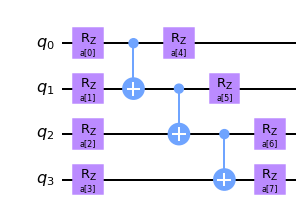

In [2]:
#Questo converge per h_anar con lambda = 0.3, maxiter di spsa 700, forse leggermente meno
qc1 = QuantumCircuit(4)
for i in range (0, 4):
    params = ParameterVector('z', 4)
    qc1.rz(params[i], i)
    params = ParameterVector('y', 4)
    qc1.ry(params[i], i)
qc = QuantumCircuit(4)
qc.cz(0,1)
qc.cz(1,2)
qc.cz(1,3)
ansatz = NLocal(num_qubits=4, 
                   rotation_blocks=qc1, 
                   entanglement_blocks=qc,
                   reps=2,
                   insert_barriers=True)
#Ansatz1 è ottimo per risolvere H_anar con lambda = 0.2, maxiter di spsa è 550
ansatz1 = TwoLocal(num_qubits=4, 
                   rotation_blocks=["rz", "ry"], 
                   entanglement_blocks="cz",
                   entanglement='full',
                   reps=2,
                   insert_barriers=True)
#Ansatz2 è ottimo per risolvere H_Arm, maxiter di spsa ho posto 300 e converge abbastanza bene
ansatz2 = TwoLocal(num_qubits=4,
                   rotation_blocks=["ry"], 
                   entanglement_blocks="cz",
                   entanglement='full',
                   reps=2,
                   insert_barriers=True)
#Ansatz2 è ottimo per risolvere H_Arm, maxiter di spsa ho posto 300 e converge abbastanza bene
ansatz3 = TwoLocal(num_qubits=4,
                   rotation_blocks=["rz"], 
                   entanglement_blocks="cx",
                   entanglement='linear',
                   reps=1,
                   insert_barriers=True)
qc = QuantumCircuit(4)
params = ParameterVector('a', 8)
for i in range(0, 4):
    qc.rz(params[i], i)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)
for i in range(0, 4):
    qc.rz(params[i+4], i)
qc.draw()

In [3]:
#definisco una funzione che va a vedere tutti i termini intermedi della vqe, più precisamente i valori
#che l'ottimizzare classico trova
def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        parameter.append(parameters)
        standard.append(std)

#Questa è la matrice di una hamiltoniana armonica unidimensionale
H_arm = (8 * I ^ I ^ I ^ I) + (-1/2* I ^ I ^ I ^ Z) + (-1 * I ^ I ^ Z ^ I) + \
            (-2 * I ^ Z ^ I ^ I) + (-4 * Z ^ I ^ I ^ I)

"""
#Questa è la matrice di una hamiltoniana anarmonica con s = 0.2 senza i termini con 10^(-16)
H_anar = (29.75 * I ^ I ^ I ^ I) + (-0.5 * I ^ I ^ I ^ Z) + (15.3757 * I ^I ^ X ^ I) + \
            (-0.150925 * I^I^X^Z) + \
            (-1.9 * I^I^Z^I) + (- 2.1 * I^I^Z^Z) + (3.99872 * I^X^I^I) + \
            (-0.400411 * I^X^I^Z) + (8.01247 * I^X^X^I) + \
            (-0.800007 * I^X^X^Z) + \
            (-0.800659 * I^X^Z^I) + \
            (0.0497082 * I^X^Z^Z) + \
            (8.01247 * I^Y^Y^I) + (-0.800007 * I^Y^Y^Z) +\
            (-7.7 * I^Z^I^I) + (-1.8 * I^Z^I^Z) + \
            (-4.95098 * I^Z^X^I) +(-1.0492 * I^Z^X^Z) + \
            (-2.7 * I^Z^Z^I) + (2.4 * I^Z^Z^Z) + (1.59979 * X^X^I^I) + \
            (-0.200028 * X^X^I^Z) + (3.20624 * X^X^X^I) + (-0.400001 * X^X^X^Z) + \
            (-0.400054 * X^X^Z^I) + \
            (0.0249895 * X^X^Z^Z) + \
            (-3.20624 * X^Y^Y^I) + \
            (0.400001 * X^Y^Y^Z) + \
            (3.20624 * Y^X^Y^I) + \
            (-0.400001 * Y^X^Y^Z) + (1.59979 *Y^Y^I^I) +(-0.200028 * Y^Y^I^Z) + \
            (3.20624 * Y^Y^X^I) + (-0.400001 * Y^Y^X^Z) + \
            (-0.400054 * Y^Y^Z^I) + \
            (0.0249895 * Y^Y^Z^Z) +(-19.3 * Z^I^I^I) + (-1.2 * Z^I^I^Z) + \
            (-11.351 * Z^I^X^I) + (-0.649199 * Z^I^X^Z) +\
            (-1.5 * Z^I^Z^I) + (2.4 * Z^I^Z^Z) + (-3.2011 * Z^X^I^I) + \
            (0.199604 * Z^X^I^Z) +(-6.40002 * Z^X^X^I) + (0.399994 * Z^X^X^Z) + \
            (0.399371 * Z^X^Z^I) + (-0.000287982 * Z^X^Z^Z) +\
            (-6.40002 * Z^Y^Y^I) + (0.399994 * Z^Y^Y^Z) + \
            (0.9 * Z^Z^I^I) + (2.4 * Z^Z^I^Z) + \
            (1.75075 * Z^Z^X^I) + (1.44908 * Z^Z^X^Z) + \
            (3.9 * Z^Z^Z^I) + (-2.4 * Z^Z^Z^Z)

H_anar = (+40.625 *I^I^I^I) +(- 0.5 *I^I^I^Z) + (23.0636 *I^I^X^I) + \
            (-0.226387 *I^I^X^Z) + (-2.35 *I^I^Z^I) +(-3.15 *I^I^Z^Z) + \
            (5.99808 *I^X^I^I) + (-0.600617 *I^X^I^Z) + (12.0187 *I^X^X^I) + \
            (-1.20001 *I^X^X^Z) + \
            (-1.20099 *I^X^Z^I) + \
            (0.0745623 *I^X^Z^Z) + \
            (12.0187 *I^Y^Y^I) + (-1.20001 *I^Y^Y^Z) +(-10.55 *I^Z^I^I) + \
            (-2.7 *I^Z^I^Z) + (-7.42647 *I^Z^X^I) + \
            (-1.57379 *I^Z^X^Z) + \
            (-4.05 *I^Z^Z^I) + (3.6 *I^Z^Z^Z) + (2.39968 *X^X^I^I) + \
            (-0.300042 *X^X^I^Z) + (4.80937 *X^X^X^I) + \
            (-0.600001 *X^X^X^Z) + \
            (-0.600081 *X^X^Z^I) + \
            (0.0374842 *X^X^Z^Z) + (-4.80937 *X^Y^Y^I) + \
            (0.600001 *X^Y^Y^Z) + (4.80937 *Y^X^Y^I) + \
            (-0.600001 *Y^X^Y^Z) + (2.39968 *Y^Y^I^I) + (-0.300042 *Y^Y^I^Z) + \
            (4.80937 *Y^Y^X^I) + \
            (-0.600001 *Y^Y^X^Z)  + \
            (-0.600081 *Y^Y^Z^I) + (0.0374842 *Y^Y^Z^Z) + (-26.95 *Z^I^I^I) + \
            (-1.8 *Z^I^I^Z) + (-17.0265 *Z^I^X^I) + \
            (-0.973799 *Z^I^X^Z) + \
            (-2.25 *Z^I^Z^I) + (3.6 *Z^I^Z^Z) + (-4.80165 *Z^X^I^I) + \
            (0.299406 *Z^X^I^Z) + (-9.60003 *Z^X^X^I) + \
            (0.599991 *Z^X^X^Z) + \
            (0.599057 *Z^X^Z^I) + \
            (-0.000431973 *Z^X^Z^Z) + \
            (-9.60003 *Z^Y^Y^I) + (0.599991 *Z^Y^Y^Z) + (1.35 *Z^Z^I^I) + \
            (3.6 *Z^Z^I^Z) + (2.62613 *Z^Z^X^I) + (2.17362 *Z^Z^X^Z) + \
            (5.85 *Z^Z^Z^I) + (-3.6 *Z^Z^Z^Z)
"""
#qui definisco il gradiente che poi utilizzerò nella vqe
expectation = StateFn(H_arm, is_measurement=True) @ StateFn(ansatz3.decompose())
gradient = Gradient(grad_method='lin_comb').convert(expectation)
#print(gradient)
"""

#Mi assicuro che l'hamiltoniana sia giusta
Matrice = StateFn(H_anar).to_matrix_op()
print(Matrice)

"""
#Trovo tutti gli autovalori dell'hamiltoniana
Eigensolver = NumPyEigensolver(k = 16).compute_eigenvalues(operator = H_arm).eigenvalues.real
print(Eigensolver)

#Trovo il minimo autovalore dell'hamiltoniana, impongo questo metodo perchè quello sopra lo uso per vedere
#se quando trovo un valore enorme è perchè ha trovato un altro autovalore
npme = NumPyMinimumEigensolver()
result_classic = npme.compute_minimum_eigenvalue(operator=H_arm)
ref_value = result_classic.eigenvalue.real

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5]


In [4]:
#setto tutto per usare un pc quantistico
"""
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
"""
backend = Aer.get_backend("qasm_simulator")
#backend = Aer.get_backend("aer_simulator_statevector")
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend("ibmq_manila")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())



#trovo i valori minimi usando il vqe, tengo traccia del tempo necessario
start_time = time.time()
quantum_instance = QuantumInstance(backend=backend, 
                                    shots= 2000,
                                    noise_model=noise_model, 
                                    coupling_map=coupling_map,
                                    measurement_error_mitigation_cls=CompleteMeasFitter)

/tmp/ipykernel_84609/2399139212.py:11: DeprecationWarning: Passing BackendProperties instead of a "backend" object has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date. Duration dependent delay relaxation noise requires a backend object.
  noise_model = NoiseModel.from_backend(device.properties())


In [5]:
counts = []
values = []
parameter = []
standard = []
Minimo_vqe = []
start_lr=0.01; end_lr=0.001; iterations=300; lr=[( start_lr - ((start_lr-end_lr)/float(iterations))*i) for i in range(iterations)]
start_pert=0.0001; end_pert=0.00001; pert=[( start_pert - ((start_pert-end_pert)/float(iterations))*i) for i in range(iterations)]
vqe = VQE(ansatz3, 
          optimizer = SPSA(maxiter=300),
          quantum_instance = quantum_instance,
          gradient=gradient,
          callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(operator=H_arm)
circuit = vqe.expectation
Minimo_vqe.append(np.real(result.optimal_value))
costo_ottimale = vqe.get_optimal_cost()

#Printo il tempo impiegato
print("Sono stati impiegati %s secondi" % (time.time() - start_time))

#Printo i risultati ottenuti
print('Il risultato esatto è:', ref_value)
print("Il risultato del VQE è:", Minimo_vqe[0])
Errore = abs(Minimo_vqe[0] - ref_value)/ref_value * 100
print("L'errore relativo del", Errore, "%")

Sono stati impiegati 60.44392156600952 secondi
Il risultato esatto è: 0.5
Il risultato del VQE è: 0.5369999999999993
L'errore relativo del 7.399999999999851 %


/tmp/ipykernel_84609/2888798127.py:16: DeprecationWarning: 
The VQE.get_optimal_cost method is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
This information is part of the returned result object and can be
queried as VQEResult.eigenvalue.
  costo_ottimale = vqe.get_optimal_cost()


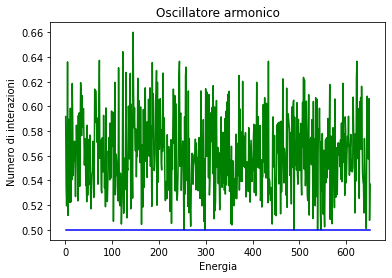

In [6]:
vero=[]
#plt.xlim(650, 700)
#plt.ylim(0,0.6)
vqe_graf = plt.plot(counts, 
                    values, 
                    color="green", 
                    linestyle="solid",
                    label='VQE')
n = len(counts)
for i in range (0,n):
    vero.append(ref_value)

giusto_graf = plt.plot(counts, 
                       vero, 
                       color="blue", 
                       linestyle="solid",
                       label="Valore teorico")
plt.title("Oscillatore armonico")
plt.xlabel("Energia")
plt.ylabel("Numero di interazioni")
plt.show()
plt.close('all')

In [7]:
def punto_iniziale(valori, parametri, risultato):
    
    lung_param = len(parameter)
    inizio_param = lung_param-150
    
    inizio = parametri[inizio_param]
    valore_iniziale = valori[inizio_param]
    passo_0 = abs(valore_iniziale - risultato)
    
    for i in range (inizio_param, lung_param):
        passo_i = abs(valori[i] - risultato)
        if passo_i == 0:
            inizio = parametri[i]
            i = lung_param-1
        elif passo_i < passo_0:
            inizio = parametri[i]
            valore_iniziale = valori[i]
            passo_0 = abs(valore_iniziale - ref_value)
        else:
            pass
    
    return inizio

Caso 1
Sono stati impiegati 46.38761568069458 secondi
Il risultato del VQE è: 0.5199999999999997


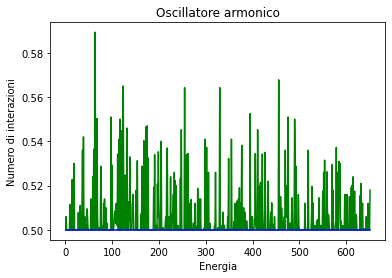

Caso 2
Sono stati impiegati 46.60339903831482 secondi
Il risultato del VQE è: 0.5414999999999995


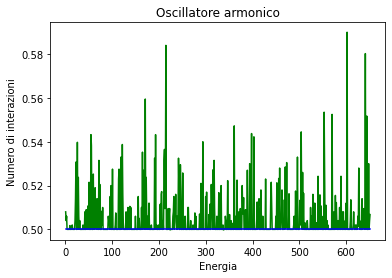

Caso 3
Sono stati impiegati 46.64994263648987 secondi
Il risultato del VQE è: 0.6080000000000002


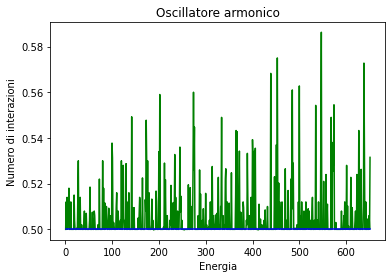

Caso 4
Sono stati impiegati 45.72273850440979 secondi
Il risultato del VQE è: 0.5270000000000006


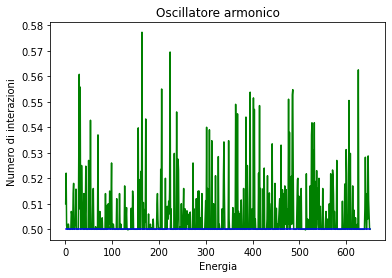

Caso 5
Sono stati impiegati 45.027490854263306 secondi
Il risultato del VQE è: 0.5747500000000005


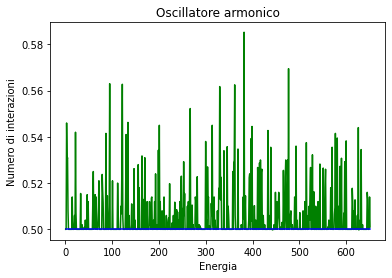

Caso 6
Sono stati impiegati 46.21212339401245 secondi
Il risultato del VQE è: 0.6004999999999994


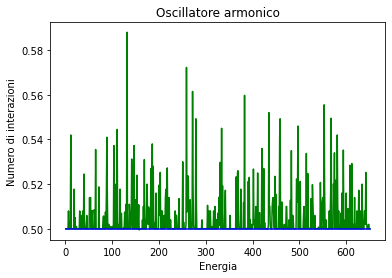

Caso 7
Sono stati impiegati 47.21355724334717 secondi
Il risultato del VQE è: 0.5749999999999995


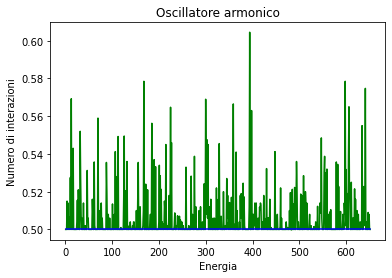

Caso 8
Sono stati impiegati 46.15860915184021 secondi
Il risultato del VQE è: 0.5570000000000005


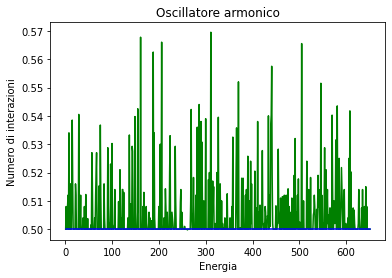

Caso 9
Sono stati impiegati 45.62083101272583 secondi
Il risultato del VQE è: 0.5789999999999996


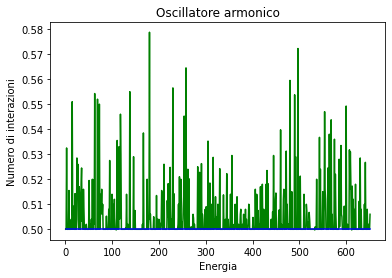

In [8]:
#Voglio graficare tutti i plot, voglio vedere cosa sta accadendo plot per plot

for i in range (1, 10):
    start_time = time.time()
#    p_ini = punto_iniziale(values, parameter, Minimo_vqe[i-1])
    counts = []
    values = []
    parameter = []
    standard = []
    vqe = VQE(ansatz3, 
              optimizer = SPSA(maxiter=300),
              quantum_instance = quantum_instance,
              gradient=gradient,
              callback=store_intermediate_result)
#              initial_point = p_ini)
    result = vqe.compute_minimum_eigenvalue(operator=H_arm)
    circuit = vqe.expectation
    Minimo_vqe.append(np.real(result.optimal_value))

    #Printo il tempo impiegato
    print("Caso", i)
    print("Sono stati impiegati %s secondi" % (time.time() - start_time))
    print("Il risultato del VQE è:", Minimo_vqe[i])
    #plt.xlim(650, 700)
    #plt.ylim(0,0.6)
    vqe_graf = plt.plot(counts, 
                        values, 
                        color="green", 
                        linestyle="solid",
                        label='VQE')

    giusto_graf = plt.plot(counts, 
                           vero, 
                           color="blue", 
                           linestyle="solid",
                           label="Valore teorico")
    plt.title("Oscillatore armonico")
    plt.xlabel("Energia")
    plt.ylabel("Numero di interazioni")
    plt.show()
    plt.close('all')

In [10]:
print("Questo è il primo risultato che ho ottenuto, non ho fatto alcuna supposizione sullo stato iniziale, rep ansatz = 1, cx come entagle gate: 0.6693684132079676 ± 0.06805416544185774, 30 circuiti studiati")
print("Questo è il secondo risultato che ho ottenuto, non ho fatto alcuna supposizione sullo stato iniziale, rep ansatz = 2, cz come entagle gate: 0.5348930534103904 ± 0.1307280481778922, 30 circuiti studiati")

Questo è il primo risultato che ho ottenuto, non ho fatto alcuna supposizione sullo stato iniziale, rep ansatz = 1, cx come entagle gate: 0.6693684132079676 ± 0.06805416544185774, 30 circuiti studiati
Questo è il secondo risultato che ho ottenuto, non ho fatto alcuna supposizione sullo stato iniziale, rep ansatz = 2, cz come entagle gate: 0.5348930534103904 ± 0.1307280481778922, 30 circuiti studiati
